Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
import pandas as pd
import numpy as np

import pandas_profiling

#Wrangling

In [9]:
heads = ['voter_id','status_code','party_code','last_name','first_name','middle_name',
        'prefix','suffix','sex','street_no','suffix_a','suffix_b','street_name',
        'unit_no','street_name2','street_name3','city','state','zip5','zip4',
        'mail_street_no','mail_suffa','mail_suffb','mail_street_name1','mail_unit_no',
        'mail_street_name2','mail_street_name3','mail_city','mail_state','mail_country',
        'mail_zip','birthdate','registered','ballot','county','municipality','ward',
        'district','party_voted','municipality_voted','ward_voted','district_voted',
        'election_date','election_name','election_type','election_cat','0','1']

df = pd.read_csv('VoterHistory3.csv',names=heads)

df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,9,11,20,21,22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,voter_id,status_code,party_code,last_name,first_name,middle_name,prefix,suffix,sex,street_no,suffix_a,suffix_b,street_name,unit_no,street_name2,street_name3,city,state,zip5,zip4,mail_street_no,mail_suffa,mail_suffb,mail_street_name1,mail_unit_no,mail_street_name2,mail_street_name3,mail_city,mail_state,mail_country,mail_zip,birthdate,registered,ballot,county,municipality,ward,district,party_voted,municipality_voted,ward_voted,district_voted,election_date,election_name,election_type,election_cat,0,1
0,117152599,A,UNA,ABANO,JOSEPH,E,NaN,NaN,N,202,NaN,NaN,GOLD ST,NaN,NaN,NaN,GREEN BROOK,NJ,8812.0,NaN,202,NaN,NaN,GOLD ST,NaN,NaN,NaN,GREEN BROOK,NJ,NaN,8812.0,12/19/1965,08/13/2004,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,GREEN BROOK,0.0,1.0,11/08/2016,GENERAL ELECTION,GEN,S,NaN,NaN
1,117126106,A,REP,ABANO,TERRI ANN,NaN,NaN,NaN,N,202,NaN,NaN,GOLD ST,NaN,NaN,NaN,GREEN BROOK,NJ,8812.0,NaN,202,NaN,NaN,GOLD ST,NaN,NaN,NaN,GREEN BROOK,NJ,NaN,8812.0,09/19/1969,08/09/2000,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,GREEN BROOK,0.0,1.0,11/08/2016,GENERAL ELECTION,GEN,S,NaN,NaN
2,117117093,A,UNA,ABBATEMARCO,DIANE,M,NaN,NaN,N,40,NaN,NaN,LENOX AVE,NaN,NaN,NaN,GREEN BROOK,NJ,8812.0,NaN,40,NaN,NaN,LENOX AVE,NaN,NaN,NaN,GREEN BROOK,NJ,NaN,8812.0,09/11/1956,07/20/1999,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,GREEN BROOK,0.0,1.0,11/08/2016,GENERAL ELECTION,GEN,S,NaN,NaN
3,117088849,A,REP,ABITANTE,ANDREW,M,NaN,NaN,N,4,NaN,NaN,BILTMORE DR,NaN,NaN,NaN,GREEN BROOK,NJ,8812.0,2602.0,4,NaN,NaN,BILTMORE DR,NaN,NaN,NaN,GREEN BROOK,NJ,NaN,8812.0,12/01/1963,09/30/1993,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,GREEN BROOK,0.0,1.0,11/08/2016,GENERAL ELECTION,GEN,S,NaN,NaN
4,117088849,A,REP,ABITANTE,ANDREW,M,NaN,NaN,N,4,NaN,NaN,BILTMORE DR,NaN,NaN,NaN,GREEN BROOK,NJ,8812.0,2602.0,4,NaN,NaN,BILTMORE DR,NaN,NaN,NaN,GREEN BROOK,NJ,NaN,8812.0,12/01/1963,09/30/1993,M,11700259.0,GREEN BROOK,0.0,1.0,REP,GREEN BROOK,0.0,1.0,06/02/2015,PRIMARY ELECTION,PRI,S,NaN,NaN


In [10]:
#trim the crap
crap = ['middle_name',
        'prefix','suffix','street_no','suffix_a','suffix_b',
        'unit_no','street_name2','street_name3','state','zip5','zip4',
        'mail_street_no','mail_suffa','mail_suffb','mail_street_name1','mail_unit_no',
        'mail_street_name2','mail_street_name3','mail_city','mail_state','mail_country',
        'mail_zip','municipality_voted','ward_voted','district_voted',
        'election_name','election_cat','0','1','ward']

df = df.drop(columns=crap)

df.head()

,voter_id,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,party_voted,election_date,election_type
0,117152599,A,UNA,ABANO,JOSEPH,N,GOLD ST,GREEN BROOK,12/19/1965,08/13/2004,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN
1,117126106,A,REP,ABANO,TERRI ANN,N,GOLD ST,GREEN BROOK,09/19/1969,08/09/2000,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN
2,117117093,A,UNA,ABBATEMARCO,DIANE,N,LENOX AVE,GREEN BROOK,09/11/1956,07/20/1999,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN
3,117088849,A,REP,ABITANTE,ANDREW,N,BILTMORE DR,GREEN BROOK,12/01/1963,09/30/1993,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN
4,117088849,A,REP,ABITANTE,ANDREW,N,BILTMORE DR,GREEN BROOK,12/01/1963,09/30/1993,M,11700259.0,GREEN BROOK,0.0,1.0,REP,06/02/2015,PRI


In [13]:
df['ones'] = [1] * df.shape[0]

df.head()

,voter_id,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,party_voted,election_date,election_type,ones
0,117152599,A,UNA,ABANO,JOSEPH,N,GOLD ST,GREEN BROOK,12/19/1965,08/13/2004,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN,1
1,117126106,A,REP,ABANO,TERRI ANN,N,GOLD ST,GREEN BROOK,09/19/1969,08/09/2000,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN,1
2,117117093,A,UNA,ABBATEMARCO,DIANE,N,LENOX AVE,GREEN BROOK,09/11/1956,07/20/1999,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN,1
3,117088849,A,REP,ABITANTE,ANDREW,N,BILTMORE DR,GREEN BROOK,12/01/1963,09/30/1993,M,11700259.0,GREEN BROOK,0.0,1.0,NaN,11/08/2016,GEN,1
4,117088849,A,REP,ABITANTE,ANDREW,N,BILTMORE DR,GREEN BROOK,12/01/1963,09/30/1993,M,11700259.0,GREEN BROOK,0.0,1.0,REP,06/02/2015,PRI,1


In [35]:
df['voter_id'].describe()
#21691 unique ids

count         38095
unique        21691
top       117061867
freq              5
Name: voter_id, dtype: int64

In [23]:
piv = df.pivot_table(index='voter_id',columns=['election_date'],values='ones')

print(piv.shape)
piv.head()
#hopefully, this means that voter 101001891 voted in those two elections, etc
#shape is shorter than expected -- if I had to guess, I'd say it dropped non-voters?

(15142, 5)


election_date,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016
voter_id,,,,,
101001891,NaN,NaN,1.0,NaN,1.0
101024934,1.0,1.0,1.0,1.0,1.0
101048678,NaN,NaN,NaN,NaN,1.0
101055274,1.0,1.0,1.0,1.0,1.0
101062053,NaN,1.0,1.0,1.0,1.0


In [36]:
merged = piv.merge(df.drop(columns=['party_voted','election_date','election_type']),on='voter_id',how='outer')

print(merged.shape)
merged.head()
#merged has rows of duplicates, just like the original df, 
#but we won't lose information to drop them now
#doing an outer merge should have resorted the voters that were dropped in the pivot

(38095, 21)


,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,ones
0,101001891,NaN,NaN,1.0,NaN,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,05/15/1965,10/14/2008,M,11700154.0,NORTH PLAINFIELD,0.0,1.0,1
1,101001891,NaN,NaN,1.0,NaN,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,05/15/1965,10/14/2008,M,11700154.0,NORTH PLAINFIELD,0.0,1.0,1
2,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,05/20/1932,11/16/2015,M,11700160.0,NORTH PLAINFIELD,0.0,8.0,1
3,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,05/20/1932,11/16/2015,M,11700160.0,NORTH PLAINFIELD,0.0,8.0,1
4,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,05/20/1932,11/16/2015,M,11700160.0,NORTH PLAINFIELD,0.0,8.0,1


In [39]:
merged.tail()
#Aw Hell I Never Checked For Garbage At The End

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,ones
38090,152439733,NaN,NaN,NaN,NaN,NaN,A,DEM,WILSON,VIRGINIA,F,IVY PL,NORTH PLAINFIELD,10/06/1956,08/23/2016,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38091,151401092,NaN,NaN,NaN,NaN,NaN,IF,REP,WOLF,JEFFERY,M,MALI DR,NORTH PLAINFIELD,03/19/1970,06/22/2010,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38092,150109017,NaN,NaN,NaN,NaN,NaN,IF,DEM,WORKMAN,ANGELICA,F,NETHERWOOD AVE,NORTH PLAINFIELD,12/09/1965,10/17/2006,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38093,101234852,NaN,NaN,NaN,NaN,NaN,IF,DEM,WORKMAN,RONALD,M,NETHERWOOD AVE,NORTH PLAINFIELD,12/03/1966,10/17/2006,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38094,Total Number Of Voters: 38094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [40]:
merged = merged.drop(labels=38094,axis=0)

merged.tail()
#garbage gone

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,ones
38089,117112581,NaN,NaN,NaN,NaN,NaN,A,UNA,WILSON,JAMES,N,NETHERWOOD AVE,NORTH PLAINFIELD,12/12/1961,10/05/1998,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38090,152439733,NaN,NaN,NaN,NaN,NaN,A,DEM,WILSON,VIRGINIA,F,IVY PL,NORTH PLAINFIELD,10/06/1956,08/23/2016,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38091,151401092,NaN,NaN,NaN,NaN,NaN,IF,REP,WOLF,JEFFERY,M,MALI DR,NORTH PLAINFIELD,03/19/1970,06/22/2010,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38092,150109017,NaN,NaN,NaN,NaN,NaN,IF,DEM,WORKMAN,ANGELICA,F,NETHERWOOD AVE,NORTH PLAINFIELD,12/09/1965,10/17/2006,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1
38093,101234852,NaN,NaN,NaN,NaN,NaN,IF,DEM,WORKMAN,RONALD,M,NETHERWOOD AVE,NORTH PLAINFIELD,12/03/1966,10/17/2006,NaN,11700191.0,NORTH PLAINFIELD,0.0,12.0,1


In [41]:
merged['voter_id'].describe()
#still right number of unique ids

count         38094
unique        21690
top       101136610
freq              5
Name: voter_id, dtype: object

In [42]:
dupmerged = merged.drop_duplicates(subset='voter_id',keep='first')

print(dupmerged.shape)
dupmerged.head()
#huzzah!!!!

(21690, 21)


,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,ones
0,101001891,NaN,NaN,1.0,NaN,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,05/15/1965,10/14/2008,M,11700154.0,NORTH PLAINFIELD,0.0,1.0,1
2,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,05/20/1932,11/16/2015,M,11700160.0,NORTH PLAINFIELD,0.0,8.0,1
7,101048678,NaN,NaN,NaN,NaN,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,08/29/1930,02/06/2008,M,11700157.0,NORTH PLAINFIELD,0.0,4.0,1
8,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,04/13/1944,01/10/2009,M,11700151.0,NORTH PLAINFIELD,0.0,2.0,1
13,101062053,NaN,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,10/12/1946,10/19/2009,M,11700158.0,NORTH PLAINFIELD,0.0,5.0,1


In [46]:
vh = dupmerged.copy()

vh.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,ones
0,101001891,NaN,NaN,1.0,NaN,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,05/15/1965,10/14/2008,M,11700154.0,NORTH PLAINFIELD,0.0,1.0,1
2,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,05/20/1932,11/16/2015,M,11700160.0,NORTH PLAINFIELD,0.0,8.0,1
7,101048678,NaN,NaN,NaN,NaN,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,08/29/1930,02/06/2008,M,11700157.0,NORTH PLAINFIELD,0.0,4.0,1
8,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,04/13/1944,01/10/2009,M,11700151.0,NORTH PLAINFIELD,0.0,2.0,1
13,101062053,NaN,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,10/12/1946,10/19/2009,M,11700158.0,NORTH PLAINFIELD,0.0,5.0,1


In [49]:
#replace nans in the election columns with 0s


vh['06/02/2015'] = vh['06/02/2015'].fillna(0)
vh['06/06/2017'] = vh['06/06/2017'].fillna(0)
vh['06/07/2016'] = vh['06/07/2016'].fillna(0)
vh['11/07/2017'] = vh['11/07/2017'].fillna(0)
vh['11/08/2016'] = vh['11/08/2016'].fillna(0)

vh.head()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,ward,district,ones
0,101001891,0.0,0.0,1.0,0.0,1.0,A,DEM,GORHAM,GWENDOLYN,F,MERCER AVE,NORTH PLAINFIELD,05/15/1965,10/14/2008,M,11700154.0,NORTH PLAINFIELD,0.0,1.0,1
2,101024934,1.0,1.0,1.0,1.0,1.0,A,DEM,BIVINS,DAVETTE,F,NORTH DR,NORTH PLAINFIELD,05/20/1932,11/16/2015,M,11700160.0,NORTH PLAINFIELD,0.0,8.0,1
7,101048678,0.0,0.0,0.0,0.0,1.0,A,REP,DEFROSCIA,ESTHER,N,CRYSTAL TER,NORTH PLAINFIELD,08/29/1930,02/06/2008,M,11700157.0,NORTH PLAINFIELD,0.0,4.0,1
8,101055274,1.0,1.0,1.0,1.0,1.0,A,DEM,BREWER,GERALDINE,F,HURLEY AVE,NORTH PLAINFIELD,04/13/1944,01/10/2009,M,11700151.0,NORTH PLAINFIELD,0.0,2.0,1
13,101062053,0.0,1.0,1.0,1.0,1.0,A,DEM,LEE,MARY,N,MALCOLM AVE,NORTH PLAINFIELD,10/12/1946,10/19/2009,M,11700158.0,NORTH PLAINFIELD,0.0,5.0,1


In [0]:
#don't need ones anymore, never needed ward

vh = vh.drop(columns=['ward','ones'])

In [0]:
#replace fake birthday with nan

vh['birthdate'] = vh['birthdate'].replace("01/01/1800",np.nan)

In [54]:
pandas_profiling.ProfileReport(vh)

Number of variables,20
Number of observations,21690
Total Missing (%),1.6%
Total size in memory,3.3 MiB
Average record size in memory,160.0 B
Numeric,3
Categorical,11
Boolean,5
Date,0
Text (Unique),1
Rejected,0


In [55]:
#make registration and birthdate datetimes for future feature engineering
vh['birthdate'] = vh['birthdate'].apply(pd.to_datetime)
vh['registered'] = vh['registered'].apply(pd.to_datetime)

vh.tail()

,voter_id,06/02/2015,06/06/2017,06/07/2016,11/07/2017,11/08/2016,status_code,party_code,last_name,first_name,sex,street_name,city,birthdate,registered,ballot,county,municipality,district
38089,117112581,0.0,0.0,0.0,0.0,0.0,A,UNA,WILSON,JAMES,N,NETHERWOOD AVE,NORTH PLAINFIELD,1961-12-12,1998-10-05,NaN,11700191.0,NORTH PLAINFIELD,12.0
38090,152439733,0.0,0.0,0.0,0.0,0.0,A,DEM,WILSON,VIRGINIA,F,IVY PL,NORTH PLAINFIELD,1956-10-06,2016-08-23,NaN,11700191.0,NORTH PLAINFIELD,12.0
38091,151401092,0.0,0.0,0.0,0.0,0.0,IF,REP,WOLF,JEFFERY,M,MALI DR,NORTH PLAINFIELD,1970-03-19,2010-06-22,NaN,11700191.0,NORTH PLAINFIELD,12.0
38092,150109017,0.0,0.0,0.0,0.0,0.0,IF,DEM,WORKMAN,ANGELICA,F,NETHERWOOD AVE,NORTH PLAINFIELD,1965-12-09,2006-10-17,NaN,11700191.0,NORTH PLAINFIELD,12.0
38093,101234852,0.0,0.0,0.0,0.0,0.0,IF,DEM,WORKMAN,RONALD,M,NETHERWOOD AVE,NORTH PLAINFIELD,1966-12-03,2006-10-17,NaN,11700191.0,NORTH PLAINFIELD,12.0


In [56]:
#base turnout rates for the elections are up in the profile report, but let's put them here, too

#intended target! 2017 general!
vh['11/07/2017'].value_counts(normalize=True)
#unbalanced, but not too bad at all

0.0    0.636883
1.0    0.363117
Name: 11/07/2017, dtype: float64

In [60]:
#2017 primary
vh['06/06/2017'].value_counts(normalize=True)

0.0    0.872568
1.0    0.127432
Name: 06/06/2017, dtype: float64

In [61]:
#2016 general
vh['11/08/2016'].value_counts(normalize=True)

1.0    0.670862
0.0    0.329138
Name: 11/08/2016, dtype: float64

In [62]:
#2016 primary
vh['06/07/2016'].value_counts(normalize=True)

0.0    0.760811
1.0    0.239189
Name: 06/07/2016, dtype: float64

In [63]:
#2015 primary
vh['06/02/2015'].value_counts(normalize=True)

0.0    0.946243
1.0    0.053757
Name: 06/02/2015, dtype: float64

#Modeling

In [0]:
from sklearn.model_selection import train_test_split

In [65]:
#oh god it's finally happening
train, test = train_test_split(vh)

train.shape, test.shape

((16267, 19), (5423, 19))

In [0]:
target = '11/07/2017'
features = ['11/08/2016','06/06/2017']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [71]:
#kinda silly to have a pipeline of one item but whatever
pipeline = make_pipeline(
  RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))
#a modest but legitimate improvement over the baseline!

Validation Accuracy 0.7294855246173705


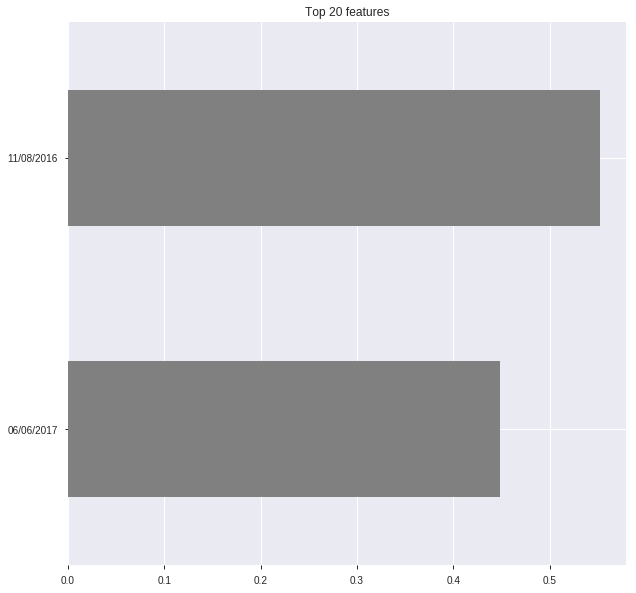

In [72]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');
#voting in the last general was more important than voting in the last primary

In [0]:
from xgboost import XGBClassifier

In [74]:
pipeline = make_pipeline(
  XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_test, y_test))
#identical to the random forest, probably because it's just two binary features

Validation Accuracy 0.7294855246173705


In [77]:
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

In [79]:
#make a random forest, fit to model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train,y_train)

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [82]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)
#cute little feature list...

Weight,Feature
0.0987 ± 0.0032,06/06/2017
0.0329 ± 0.0043,11/08/2016


##feature ideas

- voter age (on 11/07/2017)
- age when voter registered
- time when voter registered relative to 11/07/2017 (long shot)
- 'voter score'
    - number of prior elections voted in
    - number of prior elections voted in during which they were of age
    - number of prior elections voted in during which they were registered to vote
    - not number, but ratio? (over all elections or relevant elections)